In [18]:
# load dependencies
from reanalyPlotTools import reanalyPlotTools
from reanalyPlotTools import snotelPlotTools
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import glob
import netCDF4 as nc
import folium
import pandas as pd
from matplotlib import cm
import dask.array as da
import xarray
import rasterio
from scipy.linalg import svd
import datetime
from scipy import stats
import matplotlib as mpl
from pylab import boxplot
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
import math
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from matplotlib.colors import LinearSegmentedColormap
from sklearn.neighbors import KernelDensity
import itertools
import seaborn as sns
import scipy.interpolate as interp
import matplotlib.patches as patches
import scipy


# data paths and flags
dat_path = '/projects/jupf7869/500m'
dat_path2 = '/projects/jupf7869/90m'
extensionSWE = '/*SWE*'
extensionForcing = '/*FORCING*'
posteriorIdx = 2
resolution = 500
years = range(1985,2021)
wsdlurl = 'https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL'
variablecode = 'SNOTEL:WTEQ_D'
start_date = '1984-10-01'
end_date = '2020-09-30'
SWE_090 = np.load('/projects/jupf7869/90m/S_W_E_090.npy',allow_pickle=True)
SWE_480= np.load('/projects/jupf7869/500m/S_W_E_480.npy',allow_pickle=True)
SCA_090 = np.load('/projects/jupf7869/90m/S_C_A_090.npy',allow_pickle=True)
SCA_480= np.load('/projects/jupf7869/500m/S_C_A_480.npy',allow_pickle=True)

%matplotlib inline

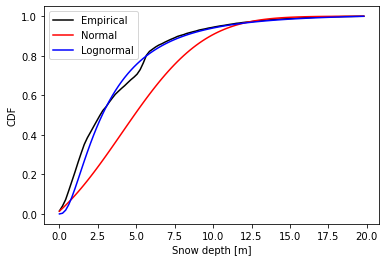

In [12]:
# Test normality versus the lidar snow depth
raster = xarray.open_rasterio('/projects/jupf7869/Niwot_snowdepth_20100520.tif')
swefile_480 = glob.glob(dat_path+'/*SWE*WY2009*')
swefile_090 = glob.glob(dat_path2+'/*SWE*WY2009*')

# do 480 normality test
mapping_480 = xarray.open_dataset(swefile_480[0]).rio.write_crs(4326).rename(Latitude='y',Longitude='x')
mapping_480 = mapping_480['SWE_Post'][0,posteriorIdx,:,:].transpose('y', 'x').load()

# create lookup grid for distribution comparisons
countUp = 0
for i in range(0,len(mapping_480.x)):
    for j in range(0,len(mapping_480.y)):
        countUp += 1
        mapping_480[j,i] = countUp 
        
# reproject the mapping to the lidar grid and do raster prep
mapping_480 = mapping_480.rio.reproject_match(raster)
raster = np.array(raster)[0,:,:]
raster[raster < -100] = np.nan
raster[raster < 0] = 0
mapping_480 = np.array(mapping_480)
mapping_480[np.isnan(raster)] = np.nan

# instantiate lists for the KS tests
KSLOGG = []
KSNORM = []

# prep distribution comparisons
xvals = np.linspace(0.01,20,100)
normMap = np.empty((mapping_480.shape))
iterate = 0
# loop through each overlapping reanalysis gridcell
for mapval in np.arange(np.nanmin(mapping_480),np.nanmax(mapping_480)):
    locs = np.where(mapping_480 == mapval,raster,np.nan)
    locs = locs[locs > 0]
    
    if len(locs) > 0:
#         perform K-S tests
        emp_cdf,_ = np.histogram(locs,xvals)
        emp_cdf = np.nancumsum(emp_cdf/np.nansum(emp_cdf))
        norm_cdf = stats.norm.pdf(xvals,loc=np.mean(locs),scale=np.std(locs))
        norm_cdf = np.nancumsum(norm_cdf/np.nansum(norm_cdf))[0:99]
        sigma = np.sqrt(np.log(1+((np.std(locs)/np.mean(locs))**2)))
        lamb = np.log(np.mean(locs))-(0.5*(sigma**2))
        logg_cdf = (1/(xvals*sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*(((np.log(xvals)-lamb)/(sigma))**2))
        logg_cdf = np.nancumsum(logg_cdf/np.nansum(logg_cdf))[0:99]

#         for demonstrations purposes, plotting and breaking
#         comment this if continuously running
        plt.plot(xvals[0:99],emp_cdf,'-k')
        plt.plot(xvals[0:99],norm_cdf,'-r')
        plt.plot(xvals[0:99],logg_cdf,'-b')
        plt.xlabel('Snow depth [m]')
        plt.ylabel('CDF')
        plt.legend(['Empirical','Normal','Lognormal'])
        break

#         calculate K-S statistic and append into list
        norm_ks = np.max(np.abs(emp_cdf-norm_cdf))
        logg_ks = np.max(np.abs(emp_cdf-logg_cdf))
        print(norm_ks,logg_ks)

        KSLOGG.append(logg_ks)
        KSNORM.append(norm_ks)

In [13]:
# Calculate PCA of subgrid snow accumulation
# Define mapping raster
reference = xarray.open_dataset(swefile_090[0]).rio.write_crs(4326).rename(Latitude='y',Longitude='x')
reference = reference['SWE_Post'][0,posteriorIdx,0:690,473:1200].transpose('y', 'x')
mapping_480 = xarray.open_dataset(swefile_480[0]).rio.write_crs(4326).rename(Latitude='y',Longitude='x')
mapping_480 = mapping_480['SWE_Post'][0,posteriorIdx,:,:].transpose('y', 'x').load()

# reproject the mapping to the 90m grid
countUp = 0
for i in range(0,len(mapping_480.x)):
    for j in range(0,len(mapping_480.y)):
        countUp += 1
        mapping_480[j,i] = countUp
# mapping = mapping.rio.reproject_match(reference,rasterio.enums.Resampling(6))
mapping = mapping_480.rio.reproject_match(reference)
                

In [10]:
# instantiate
PCA_weight1 = np.empty(mapping_480.shape)
PCA_direction1 = np.empty(mapping_480.shape)
PCA_weight2 = np.empty(mapping_480.shape)
PCA_direction2 = np.empty(mapping_480.shape)
PCA_weight3 = np.empty(mapping_480.shape)
PCA_direction3 = np.empty(mapping_480.shape)
CoV1 = np.empty(mapping_480.shape)
CoV_var1 = np.empty(mapping_480.shape)
CoV2 = np.empty(mapping_480.shape)
CoV_var2 = np.empty(mapping_480.shape)

# loop through each mapping gridcell
for mapval in range(int(mapping.min().values),int(mapping.max().values+1)):
#     determine 90m gridcells that fall within given 480m gridcell
    locs = np.where(mapping == mapval)
    if len(locs[0]) > 0:
#         filter out the snow accumulation events and normalize
        DCube = np.empty((dset_save.shape[0],locs[0].shape[0]))
        for enum_count,_ in enumerate(locs[0]):
            DCube[:,enum_count] = dset_save[:,locs[1][enum_count],locs[0][enum_count]]
        filt_nosnow = np.sum(DCube,axis=1)
        filt_nosnow = np.where(filt_nosnow > 0)[0]
        DCube = DCube[filt_nosnow,:]
        DCube[DCube < 0] = 0
        meanvals = np.tile(np.mean(DCube,axis=1),(len(locs[0]),1))
        DCube = np.transpose(DCube,(1,0)) - meanvals
    
#         perform the data decomposition
#         U is spatial patterns, leading pattern in first column U[:,0]
#         VT is temporal patterns, leading pattern in first row V[0,:]
        if DCube.shape[1] > DCube.shape[0]:
            U,s,VT = svd(DCube)
            Sigma = np.zeros(DCube.shape)
            Sigma[:DCube.shape[0],:DCube.shape[0]] = np.diag(s)
            B1 = U.dot(Sigma.dot(VT))+meanvals
            B2 = np.outer(U[:,0],Sigma[0,:].dot(VT))+meanvals

            output_locs = np.where(mapping_480 == mapval)

            PCA_weight1[output_locs[0][0],output_locs[1][0]] = s[0]
            PCA_weight2[output_locs[0][0],output_locs[1][0]] = s[1]
            PCA_weight3[output_locs[0][0],output_locs[1][0]] = s[2]
            
            temp = VT.copy()
            temp[temp > 0] = 1
            temp[temp < 0] = -1
            PCA_direction1[output_locs[0][0],output_locs[1][0]] = np.sum(temp[0,:])/len(temp[0,:])
            PCA_direction2[output_locs[0][0],output_locs[1][0]] = np.sum(temp[1,:])/len(temp[1,:])
            PCA_direction3[output_locs[0][0],output_locs[1][0]] = np.sum(temp[2,:])/len(temp[2,:])
            
#             calculate the most common accum. variability
            CoV1[output_locs[0][0],output_locs[1][0]] = np.nanmedian(np.std(B1,axis=0)/np.mean(B1,axis=0))
            CoV_var1[output_locs[0][0],output_locs[1][0]] = np.nanstd(np.std(B1,axis=0)/np.mean(B1,axis=0))
            CoV2[output_locs[0][0],output_locs[1][0]] = np.nanmedian(np.std(B2,axis=0)/np.mean(B2,axis=0))
            CoV_var2[output_locs[0][0],output_locs[1][0]] = np.nanstd(np.std(B2,axis=0)/np.mean(B2,axis=0))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


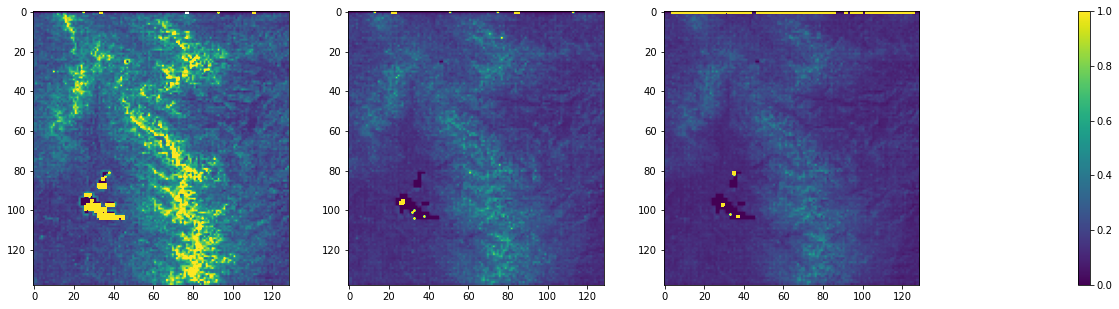

In [12]:
# plot PCA weights for three leading patterns
fig, ax = plt.subplots(1,3,figsize=(16, 10))
fig.subplots_adjust(bottom=0.5)

im = ax[0].imshow(PCA_weight1,vmin=0,vmax=1)
im = ax[1].imshow(PCA_weight2,vmin=0,vmax=1)
im = ax[2].imshow(PCA_weight3,vmin=0,vmax=1)


plot_pos = ax[2].get_position()
position=fig.add_axes([plot_pos.x0+0.36,plot_pos.y0,
                      0.01,plot_pos.y1-plot_pos.y0])
cbar1 = fig.colorbar(im,cax=position)


fig.show()

(40.005, 40.6)

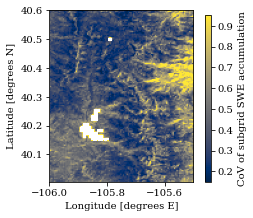

In [17]:
# plot map of snow accumulation coefficient of variations

# saved from decomposition above
COV_480 = np.load('/projects/jupf7869/500m/subgridCOV.npy')
COV_480[COV_480 < 0.1] = np.nan

mpl.font_manager._rebuild()
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

colors_runs = ['#458B74','#8A2BE2','#EE7621','#EE30A7']

COV_480 = np.load('/projects/jupf7869/500m/subgridCOV.npy')
COV_090 = np.load('/projects/jupf7869/90m/weightedAvgCV.npy')
COV_480[COV_480 < 0.1] = np.nan
COV_090[COV_090 < 0.1] = np.nan

fig = plt.figure(figsize=(4,7))

filtered_files = sorted(glob.glob(dat_path+'/*SWE*WY*'))
reference = xarray.open_dataset(filtered_files[0]).rio.write_crs(4326).rename(Latitude='y',Longitude='x')
extent = [min(reference.x),max(reference.x),min(reference.y),max(reference.y)]
ax0 = fig.add_axes([0.01,0.05,0.5,0.8])
im = ax0.imshow(COV_480[:,:],vmin=0.15,vmax=0.95,cmap='cividis',extent=extent)

cmap = fig.add_axes([0.55,0.28,0.02,0.33])
cmap = fig.colorbar(im,cax=cmap)
cmap.set_label('CoV of subgrid SWE accumulation')

ax0.set_xlabel('Longitude [degrees E]')
ax0.set_ylabel('Latitude [degrees N]')
ax0.set_xlim([-106,-105.5])
ax0.set_ylim([40.005,40.6])

[Text(2600, 0, '2600'),
 Text(2700, 0, '2700'),
 Text(2800, 0, '2800'),
 Text(2900, 0, '2900'),
 Text(3000, 0, '3000'),
 Text(3100, 0, '3100'),
 Text(3200, 0, '3200'),
 Text(3300, 0, '3300'),
 Text(3400, 0, '3400'),
 Text(3500, 0, '3500'),
 Text(3600, 0, '3600'),
 Text(3700, 0, '3700'),
 Text(3800, 0, '3800'),
 Text(3900, 0, '3900')]

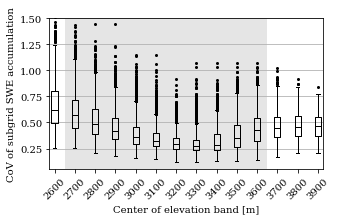

In [20]:
# same as plot above, separating into elevations bands
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# load saved data from above processes
dem_file = '/projects/jupf7869/elev_regridded_90mReanaly.tif'
dem_file = xarray.open_dataset(dem_file).rio.write_crs(4326)
swefile_480 = glob.glob(dat_path+'/*SWE*WY'+str(2015)+'*')[0]
dset_480 = xarray.open_dataset(swefile_480,chunks='auto').rio.write_crs(4326).rename(Latitude='y',Longitude='x')
dset_480 = dset_480['SWE_Post'][0,posteriorIdx,:,:].transpose('y', 'x')
dem_file = dem_file.rio.reproject_match(dset_480).to_array()[0,0,:,:]

elev_bands = np.arange(2600,4000,100)
differ = elev_bands[2]-elev_bands[1]
cov_flat = np.array(COV_480).flatten()
dem_flat = np.array(dem_file).flatten()

fig = plt.figure(figsize=(4,3))

ax = fig.add_axes([0.05,0.05,0.95,0.7])

for i,elev in enumerate(elev_bands):
    
    locs = np.where(np.abs(dem_flat-elev) <= differ)[0]
    
    vals = cov_flat[locs]
    vals = vals[~np.isnan(vals)]
    
#     print(np.mean(vals))
    
    bp = ax.boxplot(vals, positions = [elev], widths = 30,
                    medianprops=dict(color='k'),
                    flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': 'k'})

rect = patches.Rectangle( ( 2650,0), 1000, 2, alpha = 0.1, ec = 'none', fc = "k", visible = True)
ax.add_patch(rect)

ax.set_xlabel('Center of elevation band [m]')
ax.set_ylabel('CoV of subgrid SWE accumulation')
ax.set_xlim([2575,3925])
ax.set_ylim([0.05,1.5])
ax.yaxis.grid()
ax.set_xticklabels(elev_bands,rotation = 45)

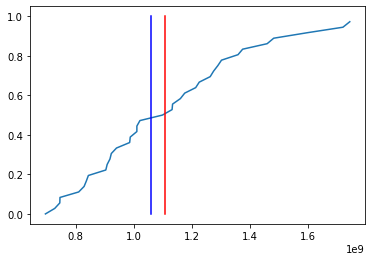

In [2]:
# calculate annual peak SWE and rank
peakSWE = reanalyPlotTools.peakSWE_distribution(dat_path,
                                                extensionSWE,posteriorIdx,480)
peakSWE_sorted = np.sort(peakSWE)

%matplotlib inline
plt.plot(peakSWE_sorted,np.divide(range(0,len(peakSWE)),len(peakSWE)))
plt.plot([np.mean(peakSWE),np.mean(peakSWE)],[0,1],'-r')
plt.plot([np.median(peakSWE),np.median(peakSWE)],[0,1],'-b')

In [3]:
# partition annual total precipitation and fraction falling as snow
PSUM,SWE_P = reanalyPlotTools.P_vs_SWEP(dat_path,extensionSWE,
                                                     extensionForcing,posteriorIdx,
                                                     peakSWE,480)

(0.2, 0.55)

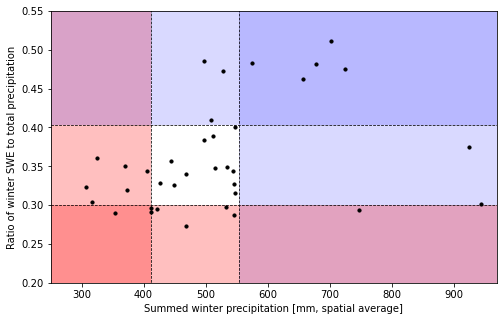

In [4]:
# partition defined using Mann-Whitney test
pctile = 27.8
PSUM_upper = np.percentile(PSUM,50+pctile)
PSUM_lower = np.percentile(PSUM,50-pctile)
SWE_P_upper = np.percentile(SWE_P,50+pctile)
SWE_P_lower = np.percentile(SWE_P,50-pctile)

fg,ax = plt.subplots(1,1,figsize=(8,5))
patch = Polygon(((200,0), (PSUM_lower,0), (PSUM_lower,1), (200,1)),
                    fc=(1,0,0,0.25), ec=(0,0,0,0), lw=2)
artst = ax.add_artist(patch)
artst.set_zorder = 0
patch = Polygon(((PSUM_upper,0), (1000,0), (1000,1), (PSUM_upper,1)),
                    fc=(0,0,1,0.15), ec=(0,0,0,0), lw=2)
artst = ax.add_artist(patch)
artst.set_zorder = 0
patch = Polygon(((200,0), (1000,0), (1000,SWE_P_lower), (200,SWE_P_lower)),
                    fc=(1,0,0,0.25), ec=(0,0,0,0), lw=2)
artst = ax.add_artist(patch)
artst.set_zorder = 0
patch = Polygon(((200,SWE_P_upper), (1000,SWE_P_upper), (1000,1), (200,1)),
                    fc=(0,0,1,0.15), ec=(0,0,0,0), lw=2)
artst = ax.add_artist(patch)
artst.set_zorder = 0

ax.plot([PSUM_lower,PSUM_lower],[0,1],'--k',lw=0.75)
ax.plot([PSUM_upper,PSUM_upper],[0,1],'--k',lw=0.75)
ax.plot([1,1000],[SWE_P_upper,SWE_P_upper],'--k',lw=0.75)
ax.plot([1,1000],[SWE_P_lower,SWE_P_lower],'--k',lw=0.75)
ax.scatter(PSUM,SWE_P,10,'k',zorder=10)
ax.set_xlabel('Summed winter precipitation [mm, spatial average]')
ax.set_ylabel('Ratio of winter SWE to total precipitation')
ax.set_xlim([250,970])
ax.set_ylim([0.20,0.55])

In [5]:
# calculate wolverine habitat by classes
dayApr15 = (date(2020,4,15)-date(2019,10,1)).days
dayMay15 = (date(2020,5,15)-date(2019,10,1)).days
SWEsave,SCAsave,ttSave,habApr15,habMay15,hot_cold,wet_dry = reanalyPlotTools.extractData(dat_path,extensionSWE,posteriorIdx,480,dayApr15,dayMay15,
                              0.40,PSUM,SWE_P,pctile,years)

# Change 1992 back to a normal year since influenced by edge-effects
hot_cold[7] = 0

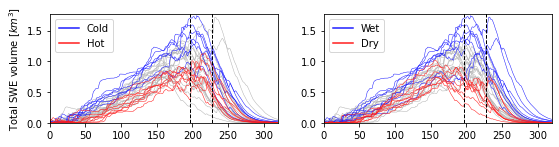

In [15]:
# SWE temporal plots for each anomaly
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,2))

dayApr15 = (date(2020,4,15)-date(2019,10,1)).days
dayMay15 = (date(2020,5,15)-date(2019,10,1)).days

# redo this top plot for the 250 m resolution only
cols = [[0.7,0.7,0.7],[0.1,0.1,1.0],[1.0,0.1,0.1]]
a = ax1.plot([-1,-2],[-1,-1],color=cols[1])
b = ax1.plot([-1,-2],[-1,-1],color=cols[2])
# subplots for hot/cold
for set in range(0,3):
    idxs = np.where(np.array(hot_cold)==set)[0]
    for idx in idxs:
        ax1.plot(SWEsave[idx,:]/(1000**3),color=cols[set],linewidth=0.5)
ax1.plot([dayApr15,dayApr15],[0,2],'--k',linewidth=1)
ax1.plot([dayMay15,dayMay15],[0,2],'--k',linewidth=1)
# ax1.set_title('Hot/cold comparison')
ax1.set_ylabel('Total SWE volume [$km^3$]')
# ax1.set_xlabel('Days since October 1st')

# subplots for wet/dry
a = ax2.plot([-1,-2],[-1,-1],color=cols[1])
b = ax2.plot([-1,-2],[-1,-1],color=cols[2])
for set in range(0,3):
    idxs = np.where(np.array(wet_dry)==set)[0]
    for idx in idxs:
        ax2.plot(SWEsave[idx,:]/(1000**3),color=cols[set],linewidth=0.5)
ax2.plot([dayApr15,dayApr15],[0,2],'--k',linewidth=1)
ax2.plot([dayMay15,dayMay15],[0,2],'--k',linewidth=1)
# ax2.set_title('Dry/wet comparison')
# ax2.set_xlabel('Days since October 1st')
ax1.set_ylim([0,1.77])
ax1.set_xlim([0,320])
ax1.legend(['Cold','Hot'])
ax2.set_ylim([0,1.77])
ax2.set_xlim([0,320])
ax2.legend(['Wet','Dry'])


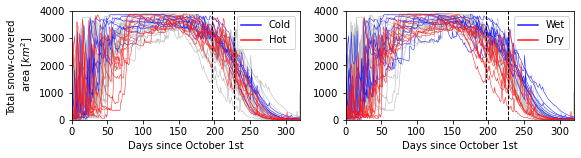

In [8]:
# SCA temporal plots for each anomaly
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,2))

dayApr15 = (date(2020,4,15)-date(2019,10,1)).days
dayMay15 = (date(2020,5,15)-date(2019,10,1)).days

# redo this top plot for the 250 m resolution only
cols = [[0.7,0.7,0.7],[0.1,0.1,1.0],[1.0,0.1,0.1]]
a = ax1.plot([-1,-2],[-1,-1],color=cols[1])
b = ax1.plot([-1,-2],[-1,-1],color=cols[2])
# subplots for hot/cold
for set in range(0,3):
    idxs = np.where(np.array(hot_cold)==set)[0]
    for idx in idxs:
        ax1.plot(SCAsave[idx,:]/(1000**2),color=cols[set],linewidth=0.5)
ax1.plot([dayApr15,dayApr15],[0,4000],'--k',linewidth=1)
ax1.plot([dayMay15,dayMay15],[0,4000],'--k',linewidth=1)
# ax1.set_title('Hot/cold comparison')
ax1.set_ylabel('Total snow-covered \n area [$km^2$]')
ax1.set_xlabel('Days since October 1st')

# subplots for wet/dry
a = ax2.plot([-1,-2],[-1,-1],color=cols[1])
b = ax2.plot([-1,-2],[-1,-1],color=cols[2])
for set in range(0,3):
    idxs = np.where(np.array(wet_dry)==set)[0]
    for idx in idxs:
        ax2.plot(SCAsave[idx,:]/(1000**2),color=cols[set],linewidth=0.5)
ax2.plot([dayApr15,dayApr15],[0,4000],'--k',linewidth=1)
ax2.plot([dayMay15,dayMay15],[0,4000],'--k',linewidth=1)
# ax2.set_title('Dry/wet comparison')
ax2.set_xlabel('Days since October 1st')

ax1.set_ylim([0,4000])
ax1.set_xlim([0,320])
ax1.legend(['Cold','Hot'],loc=1)

ax2.set_ylim([0,4000])
ax2.set_xlim([0,320])
ax2.legend(['Wet','Dry'],loc=1)

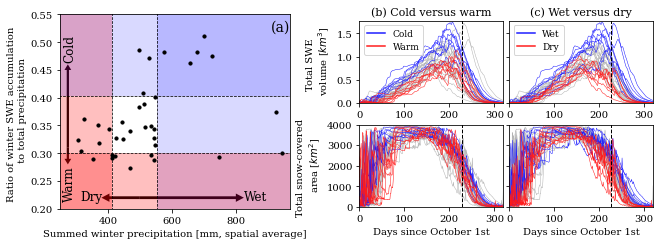

In [10]:
# combined climate plot
matplotlib.font_manager._rebuild()

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

pctile = 27.8
PSUM_upper = np.percentile(PSUM,50+pctile)
PSUM_lower = np.percentile(PSUM,50-pctile)
SWE_P_upper = np.percentile(SWE_P,50+pctile)
SWE_P_lower = np.percentile(SWE_P,50-pctile)

cols = [[0.7,0.7,0.7],[0.1,0.1,1.0],[1.0,0.1,0.1]]

fig = plt.figure(figsize=(8,3))

ax0 = fig.add_axes([0.03,0.05,0.4,0.9])
# shaded climate partition plot
patch = Polygon(((200,0), (PSUM_lower,0), (PSUM_lower,1), (200,1)),
                    fc=(1,0,0,0.25), ec=(0,0,0,0), lw=2)
artst = ax0.add_artist(patch)
artst.set_zorder = 0
patch = Polygon(((PSUM_upper,0), (1000,0), (1000,1), (PSUM_upper,1)),
                    fc=(0,0,1,0.15), ec=(0,0,0,0), lw=2)
artst = ax0.add_artist(patch)
artst.set_zorder = 0
patch = Polygon(((200,0), (1000,0), (1000,SWE_P_lower), (200,SWE_P_lower)),
                    fc=(1,0,0,0.25), ec=(0,0,0,0), lw=2)
artst = ax0.add_artist(patch)
artst.set_zorder = 0
patch = Polygon(((200,SWE_P_upper), (1000,SWE_P_upper), (1000,1), (200,1)),
                    fc=(0,0,1,0.15), ec=(0,0,0,0), lw=2)
artst = ax0.add_artist(patch)
artst.set_zorder = 0
ax0.plot([PSUM_lower,PSUM_lower],[0,1],'--k',lw=0.75)
ax0.plot([PSUM_upper,PSUM_upper],[0,1],'--k',lw=0.75)
ax0.plot([1,1000],[SWE_P_upper,SWE_P_upper],'--k',lw=0.75)
ax0.plot([1,1000],[SWE_P_lower,SWE_P_lower],'--k',lw=0.75)
ax0.scatter(PSUM,SWE_P,10,'k',zorder=10)
ax0.arrow(500,0.22,300,0,width=0.005,head_length=25,edgecolor='none',facecolor='k')
ax0.arrow(500,0.22,-95,0,width=0.005,head_length=25,edgecolor='none',facecolor='k')
ax0.annotate('Dry',(315,0.215),fontsize=12)
ax0.annotate('Wet',(825,0.215),fontsize=12)
ax0.arrow(275,0.310,0,0.14,width=7,head_length=0.01,edgecolor='none',facecolor='k')
ax0.arrow(275,0.31,0,-0.02,width=7,head_length=0.01,edgecolor='none',facecolor='k')
ax0.annotate('Warm',(260,0.22),fontsize=12,rotation=90)
ax0.annotate('Cold',(260,0.47),fontsize=12,rotation=90)
ax0.annotate('(a)',(910,0.52),fontsize=14)

ax1 = fig.add_axes([0.55,0.54,0.25,0.38])
a = ax1.plot([-1,-2],[-1,-1],color=cols[1])
b = ax1.plot([-1,-2],[-1,-1],color=cols[2])
# subplots for hot/cold
for set in range(0,3):
    idxs = np.where(np.array(hot_cold)==set)[0]
    for idx in idxs:
        ax1.plot(SWEsave[idx,:]/(1000**3),color=cols[set],linewidth=0.5)
ax1.plot([dayMay15,dayMay15],[0,2],'--k',linewidth=1)

ax2 = fig.add_axes([0.81,0.54,0.25,0.38])
a = ax2.plot([-1,-2],[-1,-1],color=cols[1])
b = ax2.plot([-1,-2],[-1,-1],color=cols[2])
for set in range(0,3):
    idxs = np.where(np.array(wet_dry)==set)[0]
    for idx in idxs:
        ax2.plot(SWEsave[idx,:]/(1000**3),color=cols[set],linewidth=0.5)
ax2.plot([dayMay15,dayMay15],[0,2],'--k',linewidth=1)

ax3 = fig.add_axes([0.55,0.06,0.25,0.38])
a = ax3.plot([-1,-2],[-1,-1],color=cols[1])
b = ax3.plot([-1,-2],[-1,-1],color=cols[2])
# subplots for hot/cold
for set in range(0,3):
    idxs = np.where(np.array(hot_cold)==set)[0]
    for idx in idxs:
        ax3.plot(SCAsave[idx,:]/(1000**2),color=cols[set],linewidth=0.5)
ax3.plot([dayMay15,dayMay15],[0,10000],'--k',linewidth=1)

ax4 = fig.add_axes([0.81,0.06,0.25,0.38])
a = ax4.plot([-1,-2],[-1,-1],color=cols[1])
b = ax4.plot([-1,-2],[-1,-1],color=cols[2])
# subplots for hot/cold
for set in range(0,3):
    idxs = np.where(np.array(wet_dry)==set)[0]
    for idx in idxs:
        ax4.plot(SCAsave[idx,:]/(1000**2),color=cols[set],linewidth=0.5)
ax4.plot([dayMay15,dayMay15],[0,10000],'--k',linewidth=1)


# # formatting
ax0.set_xlabel('Summed winter precipitation [mm, spatial average]')
ax0.set_ylabel('Ratio of winter SWE accumulation \n to total precipitation')
ax0.set_xlim([250,970])
ax0.set_ylim([0.20,0.55])

ax1.set_ylabel('Total SWE \n volume [$km^3$]')
ax1.set_ylim([0,1.77])
ax1.set_xlim([0,320])
ax1.legend(['Cold','Warm'],fontsize=9)
ax1.set_title('(b) Cold versus warm',fontsize=11)

tix = ax1.get_yticks()
ax2.set_yticks(tix)
ax2.set_yticklabels([])
ax2.set_ylim([0,1.77])
ax2.set_xlim([0,320])
ax2.legend(['Wet','Dry'],fontsize=9)
ax2.set_title('(c) Wet versus dry',fontsize=11)

ax3.set_ylabel('Total snow-covered \n area [$km^2$]')
ax3.set_xlabel('Days since October 1st')
ax3.set_xlim([0,320])
ax3.set_ylim([0,4000])

tix = ax3.get_yticks()
ax4.set_yticks(tix)
ax4.set_yticklabels([])
ax4.set_ylim([0,4000])
ax4.set_xlim([0,320])
ax4.set_xlabel('Days since October 1st')
# ax4.set_xlabel('Days since October 1st',fontname="Times New Roman") 

In [28]:
# calculate the discrete WHA
import xarray
dayMay15 = (datetime.date(2020,5,15)-datetime.date(2019,10,1)).days
dayApr15 = (datetime.date(2020,4,15)-datetime.date(2019,10,1)).days

threshold = 0.20

d500_hab_May = np.empty((1,0))
d500_thresh_May = np.empty((1,0))
d090_thresh_May = np.empty((1,0))
d090_hab_May = np.empty((1,0))

fnamesSWE = sorted(glob.glob(dat_path+'/*SWE*'))

yrvals = range(1984,2020)

# loop through each year
for file_count,year in enumerate(yrvals):
    swefile_500 = sorted(glob.glob(dat_path+'/*SWE*WY'+str(year)+'*'))
    swefile_090 = sorted(glob.glob(dat_path2+'/*SWE*WY'+str(year)+'*'))
    if len(swefile_090) > 0:
        print(swefile_500)
        dset_500 = xarray.open_dataset(swefile_500[0]).rio.write_crs(4326).rename(Latitude='y',Longitude='x')
        dset_090 = xarray.open_dataset(swefile_090[0]).rio.write_crs(4326).rename(Latitude='y',Longitude='x')
        dset_090 = dset_090['SWE_Post'][dayMay15,posteriorIdx,0:690,473:1200].transpose('y', 'x')
        dset_500 = dset_500['SWE_Post'][dayMay15,posteriorIdx,:,:].transpose('y', 'x')
        dset_500 = dset_500.rio.reproject_match(dset_090)
        discreteHabitat_d500 = np.where(np.array(dset_500) > threshold+differPend[np.where(np.array(yrvals)==year)[0][0]],1,0)
        discreteHabitat_d090 = np.where(np.array(dset_090) > threshold,1,0)
        d500_hab_May = np.append(d500_hab_May,np.sum(discreteHabitat_d500))
        d090_hab_May = np.append(d090_hab_May,np.sum(discreteHabitat_d090))
        
#         np.save('/scratch/summit/jupf7869/500m/d500_habSpatial_WY'+str(year+1),discreteHabitat_d500)
#         np.save('/scratch/summit/jupf7869/90m/d090_habSpatial_WY'+str(year+1),discreteHabitat_d090)

    else:
        d090_hab_May = np.append(d090_hab_May,np.nan)
        d500_hab_May = np.append(d500_hab_May,np.nan)
        d090_thresh_May = np.append(d090_thresh_May,np.nan)
        d500_thresh_May = np.append(d500_thresh_May,np.nan)


['/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1984_85_filt.nc']
['/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1985_86_filt.nc']
['/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1986_87_filt.nc']
['/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1987_88_filt.nc']
['/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1988_89_filt.nc']
['/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1989_90_filt.nc']
['/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1990_91_filt.nc']
['/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1991_92_filt.nc']
['/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1992_93_filt.nc']
['/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1993_94_filt.nc']
['/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1994_95_filt.nc']
['/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1995_96_fi

In [3]:
# calculate the subgrid WHA
# load the coefficient of variation data
COV_480 = np.load('/scratch/summit/jupf7869/500m/subgridCOV.npy')
COV_480[COV_480 < 0.1] = np.nan

# Specify the data to be used throughout
dayMay15 = (date(2020,5,15)-date(2019,10,1)).days
fnamesSWE = sorted(glob.glob(dat_path2+'/*SWE*'))
reference = xarray.open_dataset(fnamesSWE[0]).rio.write_crs(4326).rename(Latitude='y',Longitude='x')
reference = reference['SWE_Post'][dayMay15,posteriorIdx,0:690,473:1200].transpose('y', 'x')
threshold_May = 0.20
years = range(1985,2021)

# Specify the 480m datasets
fnamesSWE = sorted(glob.glob(dat_path+'/*SWE*'))[0:]

# Loop through each file
for file_count,file in enumerate(fnamesSWE):
    print(file)
    
#     initialize the SWE array
    SWE_steps = np.linspace(0,10,1000)
    s500_hab_May = np.empty((1,0))

#     load the data and store the sigma in the spatially-distributed array
    dset_500_2 = xarray.open_dataset(file).rio.write_crs(4326).rename(Latitude='y',Longitude='x')
    if file_count == 0:
        array_0 = dset_500_2['SWE_Post'][0,posteriorIdx,:,:].transpose('y', 'x').copy()
        temp = COV_480
        temp[temp < 0] = 0.01
        temp[temp > 2] = 2.00
        array_0.values = temp
        sigma = np.sqrt(np.log(1+array_0.values**2)).flatten()
        
        del temp
        
    SWE = dset_500_2['SWE_Post'][0:dayMay15,posteriorIdx,:,:].transpose('Day','y', 'x').values
    
    del dset_500_2

#     reshape the data and identify the dates of maximum SWE and SWE on the habitat date
    SWE = SWE.reshape((dayMay15,129*138))
    SWEpeak = np.nanmax(SWE,axis=0)
    SWEfinal = SWE[-1,:]
    
    del SWE
        
#     make the distribution
    lamb = np.ma.log(SWEpeak) - (1/2*sigma**2)
    lamb.fill_value = np.nan
    lamb = lamb.filled()
    del SWEpeak
    D = np.tile(SWE_steps, (len(lamb), 1)).T
    f_D = 1/(D*sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((np.ma.log(D)-lamb)/sigma)**2)
    f_D.fill_value = np.nan
    f_D = f_D.filled()
#     renormalize for unity
    f_D = f_D/np.nansum(f_D,axis=0)
    
#     Filter the data for only the SWE values that we need in this year
    f_D_filter = np.nanmax(f_D,axis=1)
    f_D_filter = np.nancumsum(f_D_filter/np.nansum(f_D_filter))
    f_D_filter = np.where(f_D_filter > 0.99)[0][0]   
    f_D = f_D[0:f_D_filter,:]
    f_D = f_D/np.nansum(f_D,axis=0)
    D = D[0:f_D_filter,:]
    SWE_steps = SWE_steps[0:f_D_filter]
    
    del f_D_filter
    
#     Calculate the SWEmelt that best approaches SWE on the habitat date
    SWEmelt_May = [np.nansum(f_D[i:,:]*(D[i:,:]-melt),axis=0) for i,melt in enumerate(SWE_steps)]
    SWEmelt_May = np.ravel(SWEmelt_May).reshape(len(SWE_steps),f_D.shape[1])
    SWEmelt_May = np.argmin(np.abs(SWEmelt_May-SWEfinal),axis=0)
    del SWEfinal
    SWEmelt_May = SWE_steps[SWEmelt_May]
    
    del SWE_steps
    
#     Slide the distribution by the amount of gridcell melt
    D = D-SWEmelt_May-threshold_May-differPend[file_count]  
    f_D = np.where(D < 0,0,f_D)
    del D
    
#     reshape the habitat map and store the data for future eval
    temp = np.nansum(f_D,axis=0).reshape(138,129) 
    array_0.values = temp
    subgridHabitat_s500 = array_0.rio.reproject_match(reference).values
    subgridHabitat_s500 = np.where(np.isnan(subgridHabitat_s500),0,subgridHabitat_s500)
    s500_hab_May = np.append(s500_hab_May,np.nansum(subgridHabitat_s500))
    
#     np.save('/scratch/summit/jupf7869/500m/s500_hab_May_corrected_WY'+str(years[file_count]),s500_hab_May)
#     np.save('/scratch/summit/jupf7869/500m/s500_habSpatial_WY'+str(years[file_count]),subgridHabitat_s500)

#     if file_count == 0:   
#         break

/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1984_85_filt.nc


<ipython-input-3-93e03a5279b5>:53: RuntimeWarning: divide by zero encountered in true_divide
  f_D = 1/(D*sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((np.ma.log(D)-lamb)/sigma)**2)
<ipython-input-3-93e03a5279b5>:60: RuntimeWarning: All-NaN slice encountered
  f_D_filter = np.nanmax(f_D,axis=1)


/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1985_86_filt.nc
/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1986_87_filt.nc
/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1987_88_filt.nc
/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1988_89_filt.nc
/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1989_90_filt.nc
/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1990_91_filt.nc
/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1991_92_filt.nc
/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1992_93_filt.nc
/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1993_94_filt.nc
/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1994_95_filt.nc
/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1995_96_filt.nc
/scratch/summit/jupf7869/500m/N40_0W106_0_agg_16_SWE_SCA_POST_WY1996_97_filt.nc
/scratch/summit/jupf7869/500m/N40_0W106_

0
1
2
3
4
5
6
7
8
9
10


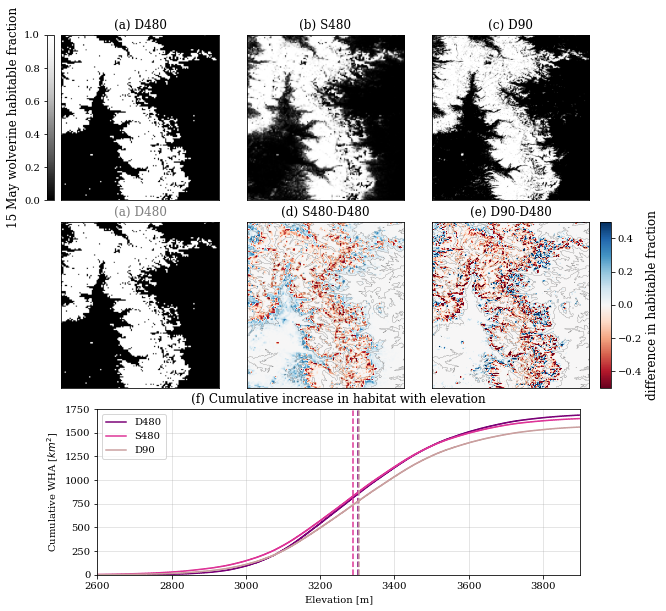

In [13]:
# Habitable fraction spatial plots

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

year = 2008

# subgridHabitat_s090 = np.load('/projects/jupf7869/90m/s090_habSpatial_WY'+str(year)+'.npy')
subgridHabitat_s500 = np.load('/projects/jupf7869/500m/s500_habSpatial_WY'+str(year)+'.npy')
discreteHabitat_d090 = np.load('/projects/jupf7869/90m/d090_habSpatial_WY'+str(year)+'.npy')
discreteHabitat_d500 = np.load('/projects/jupf7869/500m/d500_habSpatial_WY'+str(year)+'.npy')

reference = xarray.open_dataset('/projects/jupf7869/elev_regridded_90mReanaly.tif').rio.write_crs(4326).to_array()

greyscale = cm.get_cmap('Greys',1000)

fg,ax = plt.subplots(3,4,figsize=(10,8))
ax = ax.ravel()

for i,axx in enumerate(ax):
    print(i)
    if i > 9:
        break
    axx.set_xticks([])
    axx.set_yticks([])
    
    

im = ax[1].imshow(discreteHabitat_d500,vmin=0,vmax=1,cmap='Greys_r',interpolation=None)
ax[2].imshow(subgridHabitat_s500,vmin=0,vmax=1,cmap='Greys_r',interpolation=None)
ax[3].imshow(discreteHabitat_d090,vmin=0,vmax=1,cmap='Greys_r',interpolation=None)

ax[5].imshow(discreteHabitat_d500,vmin=0,vmax=1,cmap='Greys_r',interpolation=None)

# im2 = ax[6].imshow(discreteHabitat_d500-subgridHabitat_s500,vmin=-0.5,vmax=0.5,cmap='RdBu_r',interpolation=None)
im2 = ax[6].imshow(subgridHabitat_s500-discreteHabitat_d500,vmin=-0.5,vmax=0.5,cmap='RdBu',interpolation=None)
ax[6].contour(reference[0,0,:,:],colors='k',linewidths=0.15,levels=np.linspace(500,4000,10))
# ax[7].imshow(discreteHabitat_d500-discreteHabitat_d090,vmin=-0.5,vmax=0.5,cmap='RdBu_r',interpolation=None)
ax[7].imshow(discreteHabitat_d090-discreteHabitat_d500,vmin=-0.5,vmax=0.5,cmap='RdBu',interpolation=None)
ax[7].contour(reference[0,0,:,:],colors='k',linewidths=0.15,levels=np.linspace(500,4000,10))

# ax[10].imshow(subgridHabitat_s500,vmin=0,vmax=1,cmap='Greys_r',interpolation=None)

# ax[11].imshow(subgridHabitat_s500-discreteHabitat_d090,vmin=-0.5,vmax=0.5,cmap='RdBu_r',interpolation=None)
# ax[11].contour(reference[0,0,:,:],colors='k',linewidths=0.15,levels=np.linspace(500,4000,10))
    
ax[0].remove()
ax[4].remove()
ax[8].remove()
ax[9].remove()

# ax[10].remove()
ax[11].remove()


ax[1].set_title('(a) D480')
ax[2].set_title('(b) S480')
ax[3].set_title('(c) D90')

ax[5].set_title('(a) D480',alpha=0.5)

# ax[6].set_title('(d) D480-S480')
ax[6].set_title('(d) S480-D480')
# ax[7].set_title('(e) D480-D90')
ax[7].set_title('(e) D90-D480')
# ax[9].set_title('D480-S90')

# ax[10].set_title('S480')

# ax[11].set_title('S480-D90')
# ax[14].set_title('S480-S90')

# ax[18].set_title('D90')

# ax[19].set_title('D90-S90')

fg.tight_layout(pad=0.2)

plot_pos = ax[1].get_position()
position=fg.add_axes([plot_pos.x0-0.02,plot_pos.y0,
                      0.01,plot_pos.y1-plot_pos.y0])
cbar1 = fg.colorbar(im,cax=position)
position.yaxis.set_ticks_position('left')
position.yaxis.set_label_position('left')
position.set_ylabel('15 May wolverine habitable fraction',fontsize=12)

plot_pos = ax[7].get_position()
position2=fg.add_axes([1.01,plot_pos.y0,
                      0.015,plot_pos.y1-plot_pos.y0])
cbar2 = fg.colorbar(im2,cax=position2)
# position2.yaxis.set_ticks_position('left')
# position2.yaxis.set_label_position('left')
cbar2.set_label('difference in habitable fraction',fontsize=12)

dem_file = '/projects/jupf7869/elev_regridded_90mReanaly.tif'
dem_file = xarray.open_dataset(dem_file).rio.write_crs(4326)
dem_file = dem_file.rio.reproject_match(reference).to_array()[0,0,:,:]

elevs = np.ravel(dem_file)
inds = np.argsort(elevs)
xx = elevs[inds]

COLR = ['#7a0177','#dd3497','#caa0a0']

hf = discreteHabitat_d500.ravel()
yy = np.cumsum(hf[inds])*90*90/(1000*1000)
ax[10].plot(xx,yy,color=COLR[0],label='D480')
yy = np.abs(yy-(yy[-1]/2))
inds_med = np.argmin(yy)
ax[10].plot([xx[inds_med],xx[inds_med]],[0,1750],color=COLR[0],linestyle='--')

hf = subgridHabitat_s500.ravel()
yy = np.cumsum(hf[inds])*90*90/(1000*1000)
ax[10].plot(xx,yy,color=COLR[1],linestyle='-',label='S480')
yy = np.abs(yy-(yy[-1]/2))
inds_med = np.argmin(yy)
ax[10].plot([xx[inds_med],xx[inds_med]],[0,1750],color=COLR[1],linestyle='--')

hf = discreteHabitat_d090.ravel()
yy = np.cumsum(hf[inds])*90*90/(1000*1000)
ax[10].plot(xx,yy,color=COLR[2],linestyle='-',label='D90')
yy = np.abs(yy-(yy[-1]/2))
inds_med = np.argmin(yy)
ax[10].plot([xx[inds_med],xx[inds_med]],[0,1750],color=COLR[2],linestyle='--')

# ax[10].plot([np.nan,np.nan],[0,1],'--k',label='Elev. of median habitat')
ax[10].plot([np.nan,np.nan],[0,1],'--k',label='_nolegend_')

ax[10].set_xlim([2600,3900])
ax[10].set_ylim([0,1750])
# ax[10].set_ylim([0,1])
# ax[10].set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

plot_pos = ax[5].get_position()
plot_pos2 = ax[10].get_position()
ax[10].set_position([plot_pos.x0+0.05,plot_pos2.y0,0.67,
                     plot_pos2.y1-plot_pos2.y0])
ax[10].set_ylabel('Cumulative WHA [$km^2$]')
ax[10].set_xlabel('Elevation [m]')
ax[10].set_title('(f) Cumulative increase in habitat with elevation')
ax[10].grid(alpha=0.4)
ax[10].legend()

# fg.savefig('/scratch/summit/jupf7869/spatialCompare_2008.jpg', format='jpg', dpi=750, bbox_inches = "tight")



1990
-0.6871838365384618 -0.5730023348951594 -0.6372372980769229
-0.9770864711538464 -0.7979956949336676 -0.9461191153846158
2001


<ipython-input-19-fe47f35f94b9>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[countup].set_yticklabels(yarr)


-0.4205383269230769 -0.37586765863136057 -0.3581383846153843
-0.5686247596153853 -0.43585703365063433 -0.48791405769230833
2015
-0.4333481826923076 -0.4421057306284624 -0.4389423750000008
0.00985266346153846 0.01885106075578397 0.01081306730769231


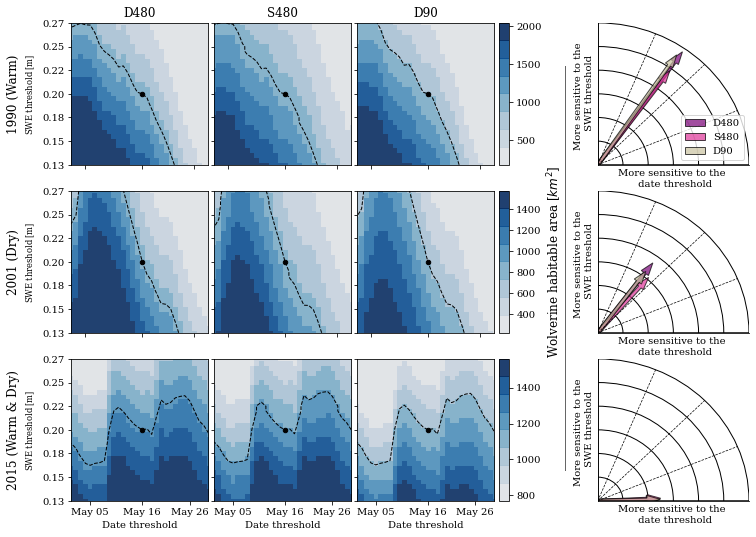

In [19]:
# threshold sensitivity plots

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

clim_anom = [' (Warm)',' (Dry)',' (Warm & Dry)']

yearval = [1990,2001,2015]
thresh_range = np.linspace(0.13,0.27,31)
cmap = mpl.cm.Blues(np.linspace(0,1,8))
cmap = mpl.colors.ListedColormap(cmap*0.9)

fg,ax = plt.subplots(3,3,figsize=(7,7))
ax = np.ravel(ax)
countup = -1
fg.tight_layout(pad=0)

for year_iter,year in enumerate(yearval):
    
    print(year)

    dayMay01= (datetime.date(year,5,1)-datetime.date(year-1,10,1)).days 
    dayMay31= (datetime.date(year,5,31)-datetime.date(year-1,10,1)).days 

    sensitivity_surface_090 = np.load('/projects/jupf7869/90m/sensitivity_surface'+str(year)+'.npy')*(90**2)/(1000**2)
    sensitivity_surface_500 = np.load('/projects/jupf7869/500m/sensitivity_surface'+str(year)+'.npy')*(90**2)/(1000**2)
    sensitivity_surface_s500 = np.load('/projects/jupf7869/500m/sensitivity_surface_s_'+str(year)+'.npy')*(90**2)/(1000**2)

    minval = np.percentile(np.dstack((sensitivity_surface_090,sensitivity_surface_500,sensitivity_surface_s500)),5)
    minval = np.floor(minval/10)*10
    maxval = np.percentile(np.dstack((sensitivity_surface_090,sensitivity_surface_500,sensitivity_surface_s500)),95)
    maxval = np.ceil(maxval/10)*10

    def fmt(x):
        s = f"{x:.0f}"
        if s.endswith("0"):
            s = f"{x:.0f}"
        return rf"{s} " if plt.rcParams["text.usetex"] else f"{s}"
    
    countup += 1
    im = ax[countup].imshow(sensitivity_surface_500,cmap=cmap,vmin=minval,vmax=maxval)
    
#     if year == 2015:
#         break
        
    ax[countup].contour(np.arange(0,dayMay31-dayMay01),np.arange(0,len(thresh_range)),sensitivity_surface_500,
                levels=[0,sensitivity_surface_500[15,15]],colors='k',linewidths=1.0,linestyles='--')
#     CS = ax[countup].contour(np.arange(0,dayMay31-dayMay01),np.arange(0,len(thresh_range)),sensitivity_surface_500,
#                 levels=np.linspace(minval,maxval,8),colors='k',linewidths=0.5)
#     ax[countup].clabel(CS, CS.levels, inline=True,fmt=fmt,fontsize=10)
    ax[countup].scatter(15,15,20,'k')
    ax[countup].set_xticks([3,15,26])
    ax[countup].set_xlim([0,29])
    ax[countup].set_ylim([0,30])
    ax[countup].set_ylabel(str(year)+clim_anom[year_iter]+'\n$\\regular_{SWE\;threshold\;[m]}$', fontsize=12)
    ticknums = ax[countup].get_yticks().astype(int)
    tickvals = np.round(thresh_range[ticknums]*100)/100
    yarr = []
    for tick in tickvals:
        yarr.append('%.2f' % tick)
    ax[countup].set_yticklabels(yarr)
#     ax[countup].set_yticklabels(tickvals)
#     ax[countup].set_yticklabels('%.2f' % tickvals)
#     >>> '%.2f' % x

    sens1 = np.gradient(sensitivity_surface_500[0:30,0:30])

    if year_iter == 0:
        ax[countup].set_title('D480')
    if year_iter == 2:
        ticknums = ax[countup].get_xticks().astype(int)
        dtarr = []
        ticknums[0] = ticknums[0] + 1
        ticknums[2] = ticknums[2] - 1
        for tick in ticknums:
            dtarr.append((datetime.date(year,5,1)+datetime.timedelta(days=int(tick))).strftime('%b %d'))
        ax[countup].set_xticks(ticknums)
        ax[countup].set_xticklabels(dtarr)
        ax[countup].set_xlabel('Date threshold')
    else:
        ax[countup].set_xticklabels([])
#     ax[countup].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

#         ax[countup].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))


#     ax1 = fg.add_axes([0.35,0.01,0.33,0.80])

    countup += 1
    poss = ax[countup].get_position()
    ax[countup].set_position([poss.x0-0.05,poss.y0,poss.x1-poss.x0,poss.y1-poss.y0])
    im = ax[countup].imshow(sensitivity_surface_s500,cmap=cmap,vmin=minval,vmax=maxval)
    ax[countup].contour(np.arange(0,dayMay31-dayMay01),np.arange(0,len(thresh_range)),sensitivity_surface_s500,
                levels=[0,sensitivity_surface_s500[15,15]],colors='k',linewidths=1.0,linestyles='--')
#     CS = ax[countup].contour(np.arange(0,dayMay31-dayMay01),np.arange(0,len(thresh_range)),sensitivity_surface_s500,
#                 levels=np.linspace(minval,maxval,8),colors='k',linewidths=0.5)
#     ax[countup].clabel(CS, CS.levels, inline=True,fmt=fmt,fontsize=10)
    ax[countup].scatter(15,15,20,'k')
    ax[countup].set_xlim([0,29])
    ax[countup].set_ylim([0,30])
    ax[countup].set_xticks([3,15,26])
    ax[countup].set_yticklabels([])
    if year_iter == 0:
        ax[countup].set_title('S480')
    if year_iter == 2:
        ticknums = ax[countup].get_xticks().astype(int)
        dtarr = []
        ticknums[0] = ticknums[0] + 1
        ticknums[2] = ticknums[2] - 1
        for tick in ticknums:
            dtarr.append((datetime.date(year,5,1)+datetime.timedelta(days=int(tick))).strftime('%b %d'))
        ax[countup].set_xticks(ticknums)
        ax[countup].set_xticklabels(dtarr)
        ax[countup].set_xlabel('Date threshold')
    else:
        ax[countup].set_xticklabels([])
        
    sens2 = np.gradient(sensitivity_surface_s500[0:30,0:30])

#     ax2 = fg.add_axes([0.69,0.01,0.33,0.80])

    countup += 1
    poss = ax[countup].get_position()
    ax[countup].set_position([poss.x0-0.10,poss.y0,poss.x1-poss.x0,poss.y1-poss.y0])
    im = ax[countup].imshow(sensitivity_surface_090,cmap=cmap,vmin=minval,vmax=maxval)
    ax[countup].contour(np.arange(0,dayMay31-dayMay01),np.arange(0,len(thresh_range)),sensitivity_surface_090,
                levels=[0,sensitivity_surface_090[15,15]],colors='k',linewidths=1.0,linestyles='--')
#     CS = ax[countup].contour(np.arange(0,dayMay31-dayMay01),np.arange(0,len(thresh_range)),sensitivity_surface_090,
#                 levels=np.linspace(minval,maxval,8),colors='k',linewidths=0.5)
#     ax[countup].clabel(CS, CS.levels, inline=True,fmt=fmt,fontsize=10)
    ax[countup].scatter(15,15,20,'k')
    ax[countup].set_xlim([0,29])
    ax[countup].set_ylim([0,30])
    ax[countup].set_xticks([3,15,26])
    ax[countup].set_yticklabels([])
    if year_iter == 0:
        ax[countup].set_title('D90')
    if year_iter == 2:
        ticknums = ax[countup].get_xticks().astype(int)
        dtarr = []
        ticknums[0] = ticknums[0] + 1
        ticknums[2] = ticknums[2] - 1
        for tick in ticknums:
            dtarr.append((datetime.date(year,5,1)+datetime.timedelta(days=int(tick))).strftime('%b %d'))
        ax[countup].set_xticks(ticknums)
        ax[countup].set_xticklabels(dtarr)
        ax[countup].set_xlabel('Date threshold')
    else:
        ax[countup].set_xticklabels([])
        
    sens3 = np.gradient(sensitivity_surface_090[0:30,0:30])


    pos = ax[countup].get_position()
    cax = fg.add_axes([pos.x1+0.01,pos.y0,0.02,pos.y1-pos.y0])
    cbar = fg.colorbar(im,cax =cax)
    if year_iter == 1:
        cbar.set_label('Wolverine habitable area [$km^2$]',fontsize=12)
        
    axx = fg.add_axes([1.09,pos.y0,0.3,pos.y1-pos.y0])  
    radii = np.linspace(0,1.35,7)
    radii = np.flip(radii)
    for rad in radii:
#         print(rad)
        circle = plt.Circle((0,0),rad,facecolor='w',edgecolor='k')
        axx.add_patch(circle)
    axx.plot([0,2],[0,0],'-k',label='_nolegend_')
    axx.plot([0,0],[2,0],'-k',label='_nolegend_')

    trig = math.sin(np.pi*(1/4))*1.35
    axx.plot([0,trig],[0,trig],'--k',linewidth=0.7,label='_nolegend_')
    trig1 = math.sin(np.pi*(1/8))*1.35
    trig2 = math.cos(np.pi*(1/8))*1.35
    axx.plot([0,trig2],[0,trig1],'--k',linewidth=0.7,label='_nolegend_')
    trig1 = math.sin(np.pi*(3/8))*1.35
    trig2 = math.cos(np.pi*(3/8))*1.35
    axx.plot([0,trig2],[0,trig1],'--k',linewidth=0.7,label='_nolegend_')
    
    xi1 = sens1[0].flatten()
    yi1 = sens1[1].flatten()
    xi1 = sum(xi1)/len(xi1)
    yi1 = sum(yi1)/len(yi1)
    xi1 = xi1/52
    yi1 = yi1/52
    xi2 = sens2[0].flatten()
    yi2 = sens2[1].flatten()
    xi2 = sum(xi2)/len(xi2)
    yi2 = sum(yi2)/len(yi2)
    xi2 = xi2/52
    yi2 = yi2/52
    xi3 = sens3[0].flatten()
    yi3 = sens3[1].flatten()
    xi3 = sum(xi3)/len(xi3)
    yi3 = sum(yi3)/len(yi3)
    xi3 = xi3/52
    yi3 = yi3/52

#     colors_runs = ['#7a0177','#dd3497','#cac2a0','#EE30A7']

    
    print(xi1,xi2,xi3)
    print(yi1,yi2,yi3)
    axx.arrow(0,0,np.abs(xi1),np.abs(yi1),width=0.03,head_width=0.08,facecolor='#7a0177',edgecolor='k',alpha=0.7,label='D480')
    axx.arrow(0,0,np.abs(xi2),np.abs(yi2),width=0.03,head_width=0.08,facecolor='#dd3497',edgecolor='k',alpha=0.7,label='S480')
    axx.arrow(0,0,np.abs(xi3),np.abs(yi3),width=0.03,head_width=0.08,facecolor='#cac2a0',edgecolor='k',alpha=0.7,label='D90')
    axx.set_xlim([0,1.35])
    axx.set_ylim([0,1.35])

    axx.spines['right'].set_visible(False)
    axx.spines['top'].set_visible(False)

    axx.set_xticks([])
    axx.set_yticks([])
    axx.set_xlabel('More sensitive to the \n date threshold')
    axx.set_ylabel('More sensitive to the \n SWE threshold')
    
    if countup == 2:
        axx.legend()
        
    line = mpl.lines.Line2D((1.025,1.025),(0.90,0.10),
                               transform=fg.transFigure,linewidth=1,color=[0.4,0.4,0.4])
    fg.lines = line,
    

fg.savefig('/scratch/summit/jupf7869/sensitivity_grid_withGrad.jpg', format='jpg', dpi=600, bbox_inches = "tight")


In [36]:
# concatenate saved habitat data
d090_hab_May = np.empty((1,0))
d500_hab_May = np.empty((1,0))
s500_hab_May = np.empty((1,0))

files1 = sorted(glob.glob('/projects/jupf7869/90m/d090_habSpatial_*.npy'))
files2 = sorted(glob.glob('/projects/jupf7869/500m/d500_habSpatial*.npy'))
for file1,file2 in zip(files1,files2):
    temp = np.load(file1)
    d090_hab_May = np.append(d090_hab_May,np.nansum(temp))
    temp = np.load(file2)
    d500_hab_May = np.append(d500_hab_May,np.nansum(temp))
 
files3 = sorted(glob.glob('/projects/jupf7869/500m/s500_hab_May_corrected_*.npy'))
for file3 in files3:
    temp = np.load(file3)
    s500_hab_May = np.append(s500_hab_May,temp)

In [37]:
# calculate smoothed gaussian kernels

d500_hab_May_conv = d500_hab_May*(90**2)/(1000**2)
d090_hab_May_conv = d090_hab_May*(90**2)/(1000**2)
s500_hab_May_conv = s500_hab_May*(90**2)/(1000**2)

bandwidths = np.linspace(0, 2500, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(d500_hab_May_conv[:, None])
grid.best_params_

/projects/jupf7869/software/anaconda/envs/reanalysis_plotTools/lib/python3.9/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [        nan -9.84848861 -8.10170107 -7.82538824 -7.73247347 -7.68883582
 -7.66667688 -7.65663152 -7.6541956  -7.65677674 -7.6627766  -7.67112064
 -7.68103548 -7.69195945 -7.70350032 -7.71540287 -7.72751737 -7.73976995
 -7.75213712 -7.76462536 -7.77725606 -7.79005522 -7.80304685 -7.81624942
 -7.82967427 -7.84332536 -7.85719986 -7.87128918 -7.88558012 -7.90005601
 -7.91469785 -7.92948513 -7.94439671 -7.95941132 -7.97450811 -7.98966694
 -8.00486868 -8.02009531 -8.03533007 -8.05055746 -8.06576328 -8.08093459
 -8.09605966 -8.11112793 -8.12612994 -8.14105727 -8.15590244 -8.17065886
 -8.18532074 -8.19988307 -8.21434148 -8.22869225 -8.24293222 -8.25705872
 -8.27106956 -8.28496295 -8.2987375  -8.31239212 -8.32592606 -8.33933882
 -8.35263012 -8.36579994 -8.37884842 -8.39177588 -8.40458279 -8.41726974
 -8.42

{'bandwidth': 202.02020202020202}

(0.0, 0.0019)

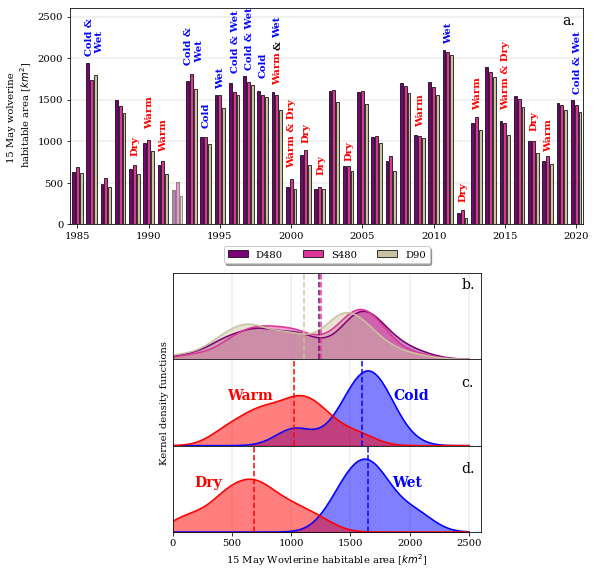

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from matplotlib.colors import LinearSegmentedColormap
from sklearn.neighbors import KernelDensity

%matplotlib inline 

hot_cold = np.load('/projects/jupf7869/500m/hot_cold.npy')
wet_dry  = np.load('/projects/jupf7869/500m/wet_dry.npy')

x = np.arange(1985,2021)
from sklearn.neighbors import KernelDensity
import matplotlib
matplotlib.font_manager._rebuild()
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

xaxvals = np.linspace(0,2500,100)
best_band = 150
kde = KernelDensity(bandwidth=best_band, kernel='gaussian')

colors = [(0.8,0.8,0.8), (0.2,0.2,1.0), (1.0,0.2,0.2)]
colors_runs = ['#7a0177','#dd3497','#cac2a0','#EE30A7']
# colors_runs = ['#458B74','#8A2BE2','#EE7621','#EE30A7']
cmap_name = 'my_list'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=3)

fg = plt.figure(figsize=(7.5,7.5))

d500_hab_May_conv = d500_hab_May*(90**2)/(1000**2)
d090_hab_May_conv = d090_hab_May*(90**2)/(1000**2)
s500_hab_May_conv = s500_hab_May*(90**2)/(1000**2)
# s090_hab_May_conv = s090_hab_May*(90**2)/(1000**2)
d500_hab_May_conv[7] = np.nan
s500_hab_May_conv[7] = np.nan
d090_hab_May_conv[7] = np.nan
# s090_hab_May_conv[7] = np.nan

ax0 = fg.add_axes([0.01,0.60,0.95,0.40])
ax0.bar(x-0.27,d500_hab_May_conv,width=0.2,color = colors_runs[0],edgecolor=(0,0,0),linewidth=0.75)
# ax0.bar(x-0.09,s500_hab_May_conv,width=0.2,color = colors_runs[1],edgecolor=(0.2,0.2,0.2),linewidth=1)
ax0.bar(x,s500_hab_May_conv,width=0.2,color = colors_runs[1],edgecolor=(0,0,0),linewidth=0.75)
# ax0.bar(x+0.09,d090_hab_May_conv,width=0.2,color = colors_runs[2],edgecolor=(0.2,0.2,0.2),linewidth=1)
ax0.bar(x+0.27,d090_hab_May_conv,width=0.2,color = colors_runs[2],edgecolor=(0,0,0),linewidth=0.75)
# ax0.bar(x+0.27,np.array(s090_hab_May_conv),width=0.2,color = colors_runs[3],edgecolor=(0.2,0.2,0.2),linewidth=1)

d500_hab_May_conv = d500_hab_May*(90**2)/(1000**2)
d090_hab_May_conv = d090_hab_May*(90**2)/(1000**2)
s500_hab_May_conv = s500_hab_May*(90**2)/(1000**2)
s090_hab_May_conv = s090_hab_May*(90**2)/(1000**2)

ax0.bar(x[7]-0.27,d500_hab_May_conv[7],width=0.2,color = colors_runs[0],edgecolor=(0.2,0.2,0.2),linewidth=1,alpha=0.5)
ax0.bar(x[7],s500_hab_May_conv[7],width=0.2,color = colors_runs[1],edgecolor=(0.2,0.2,0.2),linewidth=1,alpha=0.5)
ax0.bar(x[7]+0.27,d090_hab_May_conv[7],width=0.2,color = colors_runs[2],edgecolor=(0.2,0.2,0.2),linewidth=1,alpha=0.5)
# ax0.bar(x[7]+0.27,np.array(s090_hab_May_conv[7]),width=0.2,color = colors_runs[3],edgecolor=(0.2,0.2,0.2),linewidth=1,alpha=0.5)

ax0.annotate('Cold & \n Wet',(1985.5,2050),color='b',rotation=90,fontweight='bold')
ax0.annotate('Dry',(1988.75,850),color='r',rotation=90,fontweight='bold')
ax0.annotate('Warm',(1989.75,1170),color='r',rotation=90,fontweight='bold')
ax0.annotate('Warm',(1990.75,900),color='r',rotation=90,fontweight='bold')
# ax0.annotate('Cold',(1991.75,700),color='b',rotation=90,fontweight='bold')
ax0.annotate('Cold & \n Wet',(1992.5,1950),color='b',rotation=90,fontweight='bold')
ax0.annotate('Cold',(1993.75,1190),color='b',rotation=90,fontweight='bold')
ax0.annotate('Wet',(1994.75,1650),color='b',rotation=90,fontweight='bold')
ax0.annotate('Cold & Wet',(1995.75,1850),color='b',rotation=90,fontweight='bold')
ax0.annotate('Cold & Wet',(1996.75,1885),color='b',rotation=90,fontweight='bold')
ax0.annotate('Cold',(1997.75,1785),color='b',rotation=90,fontweight='bold')
ax0.annotate('Warm',(1998.75,1700),color='r',rotation=90,fontweight='bold')
ax0.annotate('&',(1998.75,2120),color='k',rotation=90,fontweight='bold')
ax0.annotate('Wet',(1998.75,2268),color='b',rotation=90,fontweight='bold')
ax0.annotate('Warm & Dry',(1999.75,700),color='r',rotation=90,fontweight='bold')
ax0.annotate('Dry',(2000.75,1000),color='r',rotation=90,fontweight='bold')
ax0.annotate('Dry',(2001.75,620),color='r',rotation=90,fontweight='bold')
ax0.annotate('Dry',(2003.75,795),color='r',rotation=90,fontweight='bold')
ax0.annotate('Warm',(2008.75,1200),color='r',rotation=90,fontweight='bold')
ax0.annotate('Wet',(2010.75,2200),color='b',rotation=90,fontweight='bold')
ax0.annotate('Dry',(2011.75,300),color='r',rotation=90,fontweight='bold')
ax0.annotate('Warm',(2012.75,1400),color='r',rotation=90,fontweight='bold')
ax0.annotate('Warm & Dry',(2014.75,1400),color='r',rotation=90,fontweight='bold')
ax0.annotate('Dry',(2016.75,1150),color='r',rotation=90,fontweight='bold')
ax0.annotate('Warm',(2017.75,900),color='r',rotation=90,fontweight='bold')
ax0.annotate('Cold & Wet',(2019.75,1600),color='b',rotation=90,fontweight='bold')
ax0.annotate('a.',(2019,2400),fontsize=14)

ax1 = fg.add_axes([0.2,0.35,0.57,0.16])
kde.fit(d500_hab_May_conv[:,None])
logprob = kde.score_samples(xaxvals[:,None])
ax1.fill_between(np.linspace(0,2500,100),np.exp(logprob), color=colors_runs[0], alpha=0.45)
kde.fit(s500_hab_May_conv[:,None])
logprob = kde.score_samples(xaxvals[:,None])
ax1.fill_between(np.linspace(0,2500,100),np.exp(logprob), color=colors_runs[1], alpha=0.45)
kde.fit(d090_hab_May_conv[:,None])
logprob = kde.score_samples(xaxvals[:,None])
ax1.fill_between(np.linspace(0,2500,100),np.exp(logprob), color=colors_runs[2], alpha=0.45)
# kde.fit(s090_hab_May_conv[:,None])
# logprob = kde.score_samples(xaxvals[:,None])
# ax1.fill_between(np.linspace(0,2500,100),np.exp(logprob), color=colors_runs[3], alpha=0.35)
kde.fit(d500_hab_May_conv[:,None])
logprob = kde.score_samples(xaxvals[:,None])
ax1.plot(np.linspace(0,2500,100), np.exp(logprob),color=colors_runs[0], linewidth=1.5)
kde.fit(s500_hab_May_conv[:,None])
logprob = kde.score_samples(xaxvals[:,None])
ax1.plot(np.linspace(0,2500,100), np.exp(logprob),color=colors_runs[1], linewidth=1.5)
kde.fit(d090_hab_May_conv[:,None])
logprob = kde.score_samples(xaxvals[:,None])
ax1.plot(np.linspace(0,2500,100), np.exp(logprob),color=colors_runs[2], linewidth=1.5)
# kde.fit(s090_hab_May_conv[:,None])
# logprob = kde.score_samples(xaxvals[:,None])
# ax1.plot(np.linspace(0,2500,100),np.exp(logprob), color=colors_runs[3], linewidth=1.5)
ax1.plot([np.median(d500_hab_May_conv),np.median(d500_hab_May_conv)],[0,1], color=colors_runs[0],linewidth=1.5,linestyle='--')
ax1.plot([np.median(s500_hab_May_conv),np.median(s500_hab_May_conv)],[0,1], color=colors_runs[1],linewidth=1.5,linestyle='--')
ax1.plot([np.median(d090_hab_May_conv),np.median(d090_hab_May_conv)],[0,1], color=colors_runs[2],linewidth=1.5,linestyle='--')
# ax1.plot([np.median(s090_hab_May_conv),np.median(s090_hab_May_conv)],[0,1], color=colors_runs[3],linewidth=1.5,linestyle='--')
ax1.annotate('b.',(2440,0.0013),fontsize=14)

ax2 = fg.add_axes([0.2,0.19,0.57,0.16])
# temp1 = np.hstack((d500_hab_May_conv[np.array(hot_cold) == 1],
#         s500_hab_May_conv[np.array(hot_cold) == 1],
#                  d090_hab_May_conv[np.array(hot_cold) == 1],
#                  s090_hab_May_conv[np.array(hot_cold) == 1]))
temp1 = np.hstack((d500_hab_May_conv[np.array(hot_cold) == 1],
        s500_hab_May_conv[np.array(hot_cold) == 1],
                 d090_hab_May_conv[np.array(hot_cold) == 1]))
kde.fit(temp1[:,None])
logprob = kde.score_samples(xaxvals[:,None])
ax2.fill_between(np.linspace(0,2500,100),np.exp(logprob), color = 'b',alpha=0.5)
ax2.plot(np.linspace(0,2500,100),np.exp(logprob), color = 'b',linewidth=1.5)
# temp2 = np.hstack((d500_hab_May_conv[np.array(hot_cold) == 2],
#         s500_hab_May_conv[np.array(hot_cold) == 2],
#                  d090_hab_May_conv[np.array(hot_cold) == 2],
#                  s090_hab_May_conv[np.array(hot_cold) == 2]))
temp2 = np.hstack((d500_hab_May_conv[np.array(hot_cold) == 2],
        s500_hab_May_conv[np.array(hot_cold) == 2],
                 d090_hab_May_conv[np.array(hot_cold) == 2]))
kde.fit(temp2[:,None])
logprob = kde.score_samples(xaxvals[:,None])
ax2.fill_between( np.linspace(0,2500,100),np.exp(logprob),color = 'r',alpha=0.5)
ax2.plot( np.linspace(0,2500,100),np.exp(logprob),color = 'r',linewidth=1.5)

ax2.plot([np.median(temp1),np.median(temp1)],[0,1],'--b',linewidth=1.5)
ax2.plot([np.median(temp2),np.median(temp2)],[0,1],'--r',linewidth=1.5)
ax2.annotate('Warm',(460,0.001),color='r',fontsize=14,fontweight='bold')
ax2.annotate('Cold',(1860,0.001),color='b',fontsize=14,fontweight='bold')
ax2.annotate('c.',(2440,0.0013),fontsize=14)

ax3 = fg.add_axes([0.2,0.03,0.57,0.16])
# temp1 = np.hstack((d500_hab_May_conv[np.array(wet_dry) == 1],
#         s500_hab_May_conv[np.array(wet_dry) == 1],
#                  d090_hab_May_conv[np.array(wet_dry) == 1],
#                  s090_hab_May_conv[np.array(wet_dry) == 1]))
temp1 = np.hstack((d500_hab_May_conv[np.array(wet_dry) == 1],
        s500_hab_May_conv[np.array(wet_dry) == 1],
                 d090_hab_May_conv[np.array(wet_dry) == 1]))
kde.fit(temp1[:,None])
logprob = kde.score_samples(xaxvals[:,None])
ax3.fill_between( np.linspace(0,2500,100),np.exp(logprob),color = 'b',alpha=0.5)
ax3.plot( np.linspace(0,2500,100),np.exp(logprob),color = 'b',linewidth=1.5)

# temp2 = np.hstack((d500_hab_May_conv[np.array(wet_dry) == 2],
#         s500_hab_May_conv[np.array(wet_dry) == 2],
#                  d090_hab_May_conv[np.array(wet_dry) == 2],
#                  s090_hab_May_conv[np.array(wet_dry) == 2]))
temp2 = np.hstack((d500_hab_May_conv[np.array(wet_dry) == 2],
        s500_hab_May_conv[np.array(wet_dry) == 2],
                 d090_hab_May_conv[np.array(wet_dry) == 2]))
kde.fit(temp2[:,None])
logprob = kde.score_samples(xaxvals[:,None])
ax3.fill_between(np.linspace(0,2500,100),np.exp(logprob),color = 'r',alpha=0.5)
ax3.plot(np.linspace(0,2500,100),np.exp(logprob),color = 'r',linewidth=1.5)

ax3.plot([np.median(temp1),np.median(temp1)],[0,1],'--b',linewidth=1.5)
ax3.plot([np.median(temp2),np.median(temp2)],[0,1],'--r',linewidth=1.5)
ax3.annotate('Dry',(185,0.001),color='r',fontsize=14,fontweight='bold')
ax3.annotate('Wet',(1855,0.001),color='b',fontsize=14,fontweight='bold')
ax3.annotate('d.',(2440,0.0013),fontsize=14)


# properties
ax0.set_xlim([1984.5,2020.5])
ax0.set_ylim([0,2600])
ax0.set_ylabel('15 May wolverine \n habitable area [$km^2$]')
ax0.legend(['D480','S480','D90'],loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=4)
ax0.grid(axis='y',linewidth=0.35)
ax0.set_axisbelow(True)

tix = ax0.get_yticks()
ax1.set_yticks([])
ax1.set_xticks(tix)
ax1.set_xticklabels([])
ax1.grid(axis='x',linewidth=0.35)
ax1.set_axisbelow(True)
ax1.set_xlim([0,2600])
ax1.set_ylim([0.,0.0016])

ax2.set_yticks([])
ax2.set_xticks(tix)
ax2.set_xticklabels([])
ax2.grid(axis='x',linewidth=0.35)
ax2.set_axisbelow(True)
ax2.set_ylabel('Kernel density functions')
ax2.set_xlim([0,2600])
ax2.set_ylim([0.,0.0019])

ax3.set_yticks([])
ax3.set_xticks(tix)
ax3.grid(axis='x',linewidth=0.35)
ax3.set_axisbelow(True)
ax3.set_xlabel('15 May Wovlerine habitable area [$km^2$]')
ax3.set_xlim([0,2600])
ax3.set_ylim([0.,0.0019])


In [41]:
# calculate the dominant sources of habitat disagreements
# instantiation
years = range(1985,2021)
wetcount = 0
drycount = 0
coldcount = 0
hotcount = 0

# load climate data
hot_cold = np.load('/projects/jupf7869/500m/hot_cold.npy')
wet_dry  = np.load('/projects/jupf7869/500m/wet_dry.npy')

for i,year in enumerate(years):
#     for each year, calculate the habitat differences for all combos
    ref = np.load('/projects/jupf7869/90m/d090_habSpatial_WY'+str(year)+'.npy')
    ref_new = np.load('/projects/jupf7869/500m/d500_habSpatial_WY'+str(year)+'.npy')    
    
    
    discreteHabitat_d500 = np.load('/projects/jupf7869/500m/d500_habSpatial_WY'+str(year)+'.npy')
    subgridHabitat_s500 = np.load('/projects/jupf7869/500m/s500_habSpatial_WY'+str(year)+'.npy')
    discreteHabitat_d090 = np.load('/projects/jupf7869/90m/d090_habSpatial_WY'+str(year)+'.npy')
    
    temp = ref+subgridHabitat_s500
    temp[temp > 1] = 1
    if i == 0:
        coverCount = temp
    else:
        coverCount += temp
        
    if year == 1985:

        sens_d500 = discreteHabitat_d500-ref
        sens_s500 = subgridHabitat_s500-ref
        sens_3rd = np.abs(discreteHabitat_d500-subgridHabitat_s500)
        
        sens_d500_new = ref_new-discreteHabitat_d500
        sens_s500_new = ref_new-subgridHabitat_s500
        sens_d090_new = ref_new-discreteHabitat_d090
        
        sens_d500_wet = np.zeros(sens_s500.shape)
        sens_s500_wet = np.zeros(sens_s500.shape)
        sens_3rd_wet = np.zeros(sens_3rd.shape)
        
        sens_d500_cold = np.zeros(sens_s500.shape)
        sens_s500_cold = np.zeros(sens_s500.shape)
        sens_3rd_cold = np.zeros(sens_3rd.shape)
        
        sens_d500_hot = np.zeros(sens_s500.shape)
        sens_s500_hot = np.zeros(sens_s500.shape)
        sens_3rd_hot = np.zeros(sens_3rd.shape)
        
        sens_d500_dry = np.zeros(sens_s500.shape)
        sens_s500_dry = np.zeros(sens_s500.shape)
        sens_3rd_dry = np.zeros(sens_3rd.shape)
        
    else:
#         make sure to exclude WY1992, which had artifacts
        if year != 1992:
            sens_d500 += discreteHabitat_d500-ref
            sens_s500 += subgridHabitat_s500-ref
            sens_3rd += np.abs(discreteHabitat_d500-subgridHabitat_s500)
            
            sens_d500_new += ref_new-discreteHabitat_d500
            sens_s500_new += ref_new-subgridHabitat_s500
            sens_d090_new += ref_new-discreteHabitat_d090
            
            if wet_dry[i] == 1:
                if year != 1999:
                    wetcount += 1
                    sens_d500_wet += np.abs(ref-discreteHabitat_d500)
                    sens_s500_wet += np.abs(ref-subgridHabitat_s500)
                    sens_3rd_wet += np.abs(discreteHabitat_d500-subgridHabitat_s500)

                
            if hot_cold[i] == 1:
#                 if year != 1994:
                coldcount += 1
                sens_d500_cold += np.abs(ref-discreteHabitat_d500)
                sens_s500_cold += np.abs(ref-subgridHabitat_s500)
                sens_3rd_cold += np.abs(discreteHabitat_d500-subgridHabitat_s500)

    
            if hot_cold[i] == 2:
                if year != 1999:
                    hotcount += 1
                    sens_d500_hot += np.abs(ref-discreteHabitat_d500)
                    sens_s500_hot += np.abs(ref-subgridHabitat_s500)
                    sens_3rd_hot += np.abs(discreteHabitat_d500-subgridHabitat_s500)

                
            if wet_dry[i] == 2:
                if year != 2015:
                    drycount += 1
                    sens_d500_dry += np.abs(ref-discreteHabitat_d500)
                    sens_s500_dry += np.abs(ref-subgridHabitat_s500)
                    sens_3rd_dry += np.abs(discreteHabitat_d500-subgridHabitat_s500)

# normalize concatenated data to compare classes with diff data lengths                  
sens_s500_wet = sens_s500_wet/wetcount
sens_s500_cold = sens_s500_cold/coldcount
sens_s500_hot = sens_s500_hot/hotcount
sens_s500_dry = sens_s500_dry/drycount

sens_d500_wet = sens_d500_wet/wetcount
sens_d500_cold = sens_d500_cold/coldcount
sens_d500_hot = sens_d500_hot/hotcount
sens_d500_dry = sens_d500_dry/drycount

sens_3rd_wet = sens_3rd_wet/wetcount
sens_3rd_cold = sens_3rd_cold/coldcount
sens_3rd_hot = sens_3rd_hot/hotcount
sens_3rd_dry = sens_3rd_dry/drycount


In [42]:
# load reference elevation data

elevation = xarray.open_dataset('/projects/jupf7869/elev_regridded_90mReanaly.tif').rio.write_crs(4326)
file = glob.glob('/projects/jupf7869/90m/*SWE*1985*.nc')
reference = xarray.open_dataset(file[0]).rio.write_crs(4326).rename(Latitude='y',Longitude='x')
reference = reference['SWE_Post'][0,posteriorIdx,0:690,473:1200].transpose('y', 'x')
elevation = elevation.rio.reproject_match(reference).to_array()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
['/projects/jupf7869/90m/N40_0W106_0_agg_3_SWE_SCA_POST_WY1985_86.nc']
2700
[0.1 0.1 0.1 1. ]
2800
[0.1 0.1 0.1 1. ]
2900
[0.1 0.1 0.1 1. ]
3000
[0.1 0.1 0.1 1. ]
3100
[0.25 0.25 0.7  1.  ]
3200
[0.725 0.725 0.1   1.   ]
3300
[0.725 0.725 0.1   1.   ]
3400
[1.  0.3 0.3 1. ]
3500
[1.  0.3 0.3 1. ]
3600
[0.725 0.725 0.1   1.   ]
3700
[0.725 0.725 0.1   1.   ]
3800
[0.725 0.725 0.1   1.   ]
3900
[0.725 0.725 0.1   1.   ]
4000
[0.1 0.1 0.1 1. ]
4100
[1.  0.3 0.3 1. ]


Text(0.5, 0, 'Center of elevation band [m]')

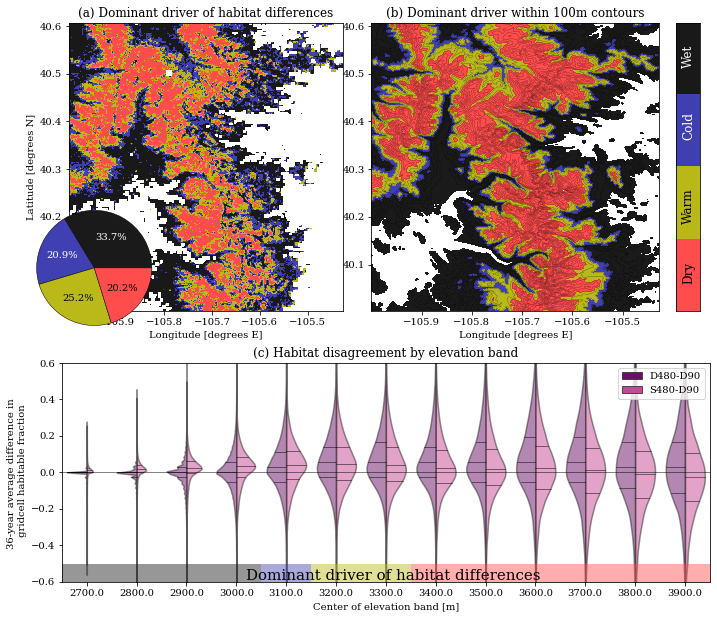

In [43]:
# create plot for dominant climate source of error
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

fg = plt.figure(figsize=(10,8))

# partition data and prep for common projection
elev_bands = np.arange(2500,4200,100)
differ = elev_bands[2]-elev_bands[1]
elev_bands = elev_bands[1:-2]
entries = np.array(elevation).flatten()
ddata = sens_d500.flatten()/36
sdata = sens_s500.flatten()/36

# initialize
entry_app = np.empty((0,))
data_app = np.empty((0,))
hue_app = np.empty((0,))
classes = []
med1,med2 = [],[]
qt1_25,qt1_75, = [], []
qt2_25,qt2_75, = [], []

# loop through each elevation band
for i,elev in enumerate(elev_bands):
    print(i)
    
    locs = np.where(np.abs(entries-elev) <= differ)[0]
    entry_app = np.hstack((entry_app,np.ones(locs.shape)*np.floor(elev),np.ones(locs.shape)*np.floor(elev)))
    data_app = np.hstack((data_app,ddata[locs],sdata[locs]))
    [classes.append('D480-D90') for _ in ddata[locs]]
    [classes.append('S480-D90') for _ in sdata[locs]]
    hue_app = np.hstack((hue_app,np.zeros(locs.shape),np.ones(locs.shape)))
    
    med1.append(np.median(ddata[locs]))
    med2.append(np.median(sdata[locs]))
    
    qt1_25.append(np.percentile(ddata[locs],25))
    qt1_75.append(np.percentile(ddata[locs],75))
    
    qt2_25.append(np.percentile(sdata[locs],25))
    qt2_75.append(np.percentile(sdata[locs],75))
    

ax4 = fg.add_axes([0.01,0.01,0.90,0.38])

ax4.plot([-10,30],[0,0],'-k',linewidth=1)

my_pal = {"D480-D90": '#7a0177', "S480-D90":'#dd3497'}

out = sns.violinplot(x=entry_app,
               y=data_app,
               hue=classes,palette=my_pal,linestyle='--',split=True,inner='quartile',ax=ax4)
for violin in out.collections:
    violin.set_alpha(0.5)
    
for l in out.lines:
    l.set_linestyle('-')
    l.set_linewidth(0.6)
    l.set_color('k')
    l.set_alpha(0.8)

f = interp.interp1d(range(0,len(qt1_25)),qt1_25)
newx = np.linspace(0,len(qt1_25)-1)
newy = f(newx)
# ax4.plot(newx,newy,color =  '#458B74',linewidth=1,linestyle='--')
f = interp.interp1d(range(0,len(qt1_75)),qt1_75)
newx = np.linspace(0,len(qt1_75)-1)
newy = f(newx)
# ax4.plot(newx,newy,color =  '#458B74',linewidth=1,linestyle='--')
f = interp.interp1d(range(0,len(qt2_25)),qt2_25)
newx = np.linspace(0,len(qt2_25)-1)
newy = f(newx)
# ax4.plot(newx,newy,color =  '#8A2BE2',linewidth=1,linestyle='--')
f = interp.interp1d(range(0,len(qt2_75)),qt2_75)
newx = np.linspace(0,len(qt2_75)-1)
newy = f(newx)
# ax4.plot(newx,newy,color =  '#8A2BE2',linewidth=1,linestyle='--')

rect = patches.Rectangle( ( 0.5,-1), 4, 0.5, alpha=0.45, ec = 'none', fc = [0.1,0.1,0.1,1.0], visible = True)
ax4.add_patch(rect)
rect = patches.Rectangle( ( 4.5,-1), 1, 0.5, alpha = 0.45, ec = 'none', fc = [0.25,0.25,0.7,1.0], visible = True)
ax4.add_patch(rect)
rect = patches.Rectangle( ( 5.5,-1), 2, 0.5, alpha = 0.45, ec = 'none', fc = [0.725,0.725,0.1,1.0], visible = True)
ax4.add_patch(rect)
rect = patches.Rectangle( ( 7.5,-1), 6, 0.5, alpha = 0.45, ec = 'none', fc = [1,0.3,0.3,1.0], visible = True)
ax4.add_patch(rect)
ax4.annotate('Dominant driver of habitat differences',(4.2,-0.59),fontsize=15)


from matplotlib.colors import LinearSegmentedColormap

file = glob.glob('/projects/jupf7869/90m/*SWE*1985*.nc')
print(file)
reference = xarray.open_dataset(file[0]).rio.write_crs(4326).rename(Latitude='y',Longitude='x')
reference = reference['SWE_Post'][0,posteriorIdx,0:690,473:1200].transpose('y', 'x')
extent=[min(reference.x).values,max(reference.x).values,min(reference.y).values,max(reference.y).values]

xmin = reference.x[50].values
xmax = reference.x[220].values
ymin = reference.y[50].values
ymax = reference.y[350].values

stack_d500 = np.dstack(((sens_d500_wet+sens_s500_wet+sens_3rd_wet)/3,
                        (sens_d500_cold+sens_s500_cold+sens_3rd_cold)/3,
                        (sens_d500_hot+sens_s500_hot+sens_3rd_hot)/3,
                        (sens_d500_dry+sens_s500_dry+sens_3rd_dry)/3))
stack_d500 = np.argmax(stack_d500,axis=2).astype(float)
stack_d500[coverCount < 1] = np.nan
pie_d500 = [len(stack_d500[stack_d500 == 0]),
           len(stack_d500[stack_d500 == 1]),
           len(stack_d500[stack_d500 == 2]),
           len(stack_d500[stack_d500 == 3])]

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
colors = np.flipud([[1,0.3,0.3],[0.725,0.725,0.1],[0.25,0.25,0.7],[0.1,0.1,0.1]])
mapvals = ListedColormap(colors)

ax0 = fg.add_axes([0.01,0.48,0.40,0.50])
im = ax0.imshow(stack_d500,vmin=0,vmax=3,cmap=mapvals,extent=extent,interpolation=None)
# ax0.plot([xmin,xmax,xmax,xmin,xmin],[ymin,ymin,ymax,ymax,ymin],color=(0.9,0.9,0.9),
#         linewidth=1.9,linestyle='-')

ax1 = fg.add_axes([0.44,0.48,0.40,0.50])

elev_bands = np.arange(2700,4200,100)
stackD = stack_d500.flatten()
for i,elev in enumerate(elev_bands):
    
    print(elev)
    locs = np.where(np.abs(entries-elev) <= differ)[0]

    prom_value = scipy.stats.mode(stackD[locs])
    print(np.append(colors[int(prom_value[0])],1.0))
    

    colval = np.append(colors[int(prom_value[0])],1.0).reshape(-1,4)
    if i == len(elev_bands)-1:
        colval = np.append(colors[3],1.0).reshape(-1,4)

    ax1.contourf(np.flipud(elevation[0,0,:,:]),levels=[elev-differ,elev+differ],colors=colval,extent=extent)
    
ax1.contour(np.flipud(elevation[0,0,:,:]),levels=elev_bands,linewidths=0.2,colors='k',extent=extent)

# ax1.imshow(stack_s500,vmin=0,vmax=3,cmap=mapvals,extent=extent,interpolation=None)

ax2 = fg.add_axes([-0.07,0.43,0.25,0.25])
_, _, autotexts = ax2.pie(pie_d500,startangle=0,colors = colors,autopct='%1.1f%%',
                         wedgeprops={"edgecolor":"k",'linewidth': 0.5})
for i,autotext in enumerate(autotexts):
    if i >= 2:
        autotext.set_color('black')
    else:
        autotext.set_color('white')
        
cax = fg.add_axes([0.79,0.48,0.18,0.50])
cax.imshow(np.array([[0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3],[0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3]]).T,cmap=mapvals)
cax.annotate('Dry',(0,21),rotation=90,fontsize=12)
cax.annotate('Warm',(0,16),rotation=90,fontsize=12)
cax.annotate('Cold',(0,9),rotation=90,fontsize=12,color='w')
cax.annotate('Wet',(0,3),rotation=90,fontsize=12,color = 'w')
cax.set_xlim([-0.5,1.5])
cax.set_yticks([])
cax.set_xticks([])
    
ax0.set_title('(a) Dominant driver of habitat differences')
ax0.set_ylabel('Latitude [degrees N]')
ax0.set_xlabel('Longitude [degrees E]')

ax1.set_title('(b) Dominant driver within 100m contours')
ax1.set_xlabel('Longitude [degrees E]')
                
ax4.set_ylim([-0.6,0.6])
ax4.set_xlim([0.5,13.5])
ax4.set_title('(c) Habitat disagreement by elevation band')
ax4.set_ylabel('36-year average difference in \n gridcell habitable fraction')
ax4.set_xlabel('Center of elevation band [m]')
